In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sklearn
from sklearn import preprocessing

import math
import argparse
import torch
import torch.utils.tensorboard
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn.utils import clip_grad_norm_
from tqdm.auto import tqdm

from utils.misc import *
from utils.utils_score import *

from dataset.load_data_generated import *
from models.vae_gaussian import *

In [133]:
ckpt_file

'graph_diffusion_refinement/36l8dgy2/checkpoints/epoch=7333-step=31039.ckpt'

In [28]:
import glob
from models.refiner import Refiner
runid = '2iqjjt48'
ckpt_file = glob.glob(f'graph_diffusion_refinement/{runid}/checkpoints/epoch*.ckpt')[0]
ckpt_file = f'graph_diffusion_refinement/{runid}/checkpoints/last.ckpt'
model_denoise = Refiner.load_from_checkpoint(ckpt_file)

args = model_denoise.hparams
model_denoise = model_denoise.generator.to('cuda')

In [20]:
from models.transformer import Transformer

# model_id = args.diffusion_model
# model = Transformer.load_from_checkpoint(f'./graph_diffusion_perceptron/{model_id}/checkpoints/last.ckpt')
diffusion_model_path = glob.glob(f'graph_diffusion_perceptron/{args.diffusion_model}/checkpoints/epoch*.ckpt')[0]
model = Transformer.load_from_checkpoint(diffusion_model_path)
model.eval()
pass

In [21]:
datasetname=model.hparams.dataset
point_dimns = model.hparams.k

train_set = LaplacianDatasetNX(datasetname,'data/'+datasetname,point_dim=model.hparams.k, smallest=model.hparams.smallest, split='train')
test_set = LaplacianDatasetNX(datasetname,'data/'+datasetname,point_dim=model.hparams.k, smallest=model.hparams.smallest, split='test')

Point dim 32
Tot #200
compute graphs statistics
computing degree:  tensor(0.0008)
computing cluster:  tensor(0.0315)
computing spectral:  tensor(0.0026)
Point dim 32
Tot #200


In [41]:
train_set[0]

(tensor([[-0.0218,  0.0426, -0.1463,  ..., -0.2000, -0.0429,  0.0863],
         [ 0.0031,  0.0431,  0.0122,  ...,  0.0060, -0.5324, -0.2216],
         [ 0.0120, -0.0095,  0.0242,  ..., -0.1540, -0.0110, -0.1354],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 tensor([0.0490, 0.2624, 0.4713, 0.5105, 0.6088, 0.7078, 0.7656, 0.6619, 0.6471,
         0.6867, 0.7805, 0.7540, 0.8000, 0.8306, 0.8045, 0.8070, 0.7763, 0.8108,
         0.7933, 0.6995, 0.6375, 0.6177, 0.6163, 0.5981, 0.6253, 0.6227, 0.6187,
         0.6324, 0.6231, 0.6661, 0.6752, 0.7092]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 

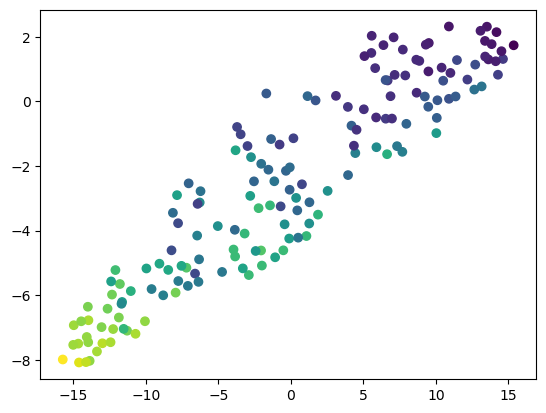

In [43]:
import sklearn.manifold
X = torch.stack([g[1] for g in train_set])
n = torch.stack([g[-2] for g in train_set])
x = sklearn.manifold.TSNE(2).fit_transform(X)

plt.scatter(x[:,0],x[:,1],c=n)


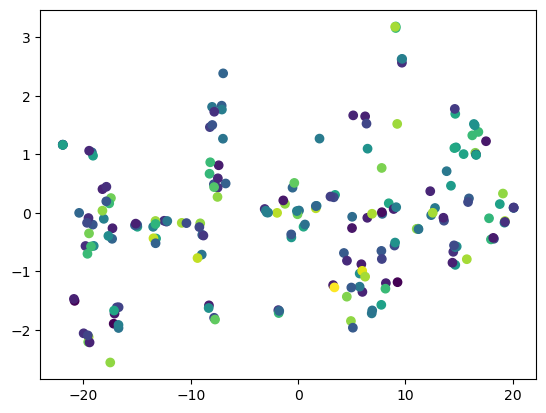

In [50]:

x = sklearn.manifold.TSNE(2).fit_transform(yy_all[:,0].data.cpu())
plt.scatter(x[:,0],x[:,1],c=n_nodes)

In [9]:
# model_denoise = torch.load(f'data/{datasetname}_{point_dimns}{args.smallest}.model')
# model_denoise = torch.load('./data/'+datasetname+'_generator.torch')
# model_denoise.to('cuda')
pass

# model_denoise = torch.load('./data/'+args.dataset+'_generator.torch')
# discriminator = torch.load('./data/'+args.dataset+'_discriminator.torch')

In [65]:
len(n_nodes)

400

In [49]:
# Reference Point Clouds
model.eval()
model.to('cuda')

n_folds = 5
n,k = train_set[0][0].shape
n_graphs = len(test_set)*n_folds
n_nodes = list(train_set.sample_n_nodes(n_graphs-1)) + [train_set.n_max]

# def sample_eigs(self, max_nodes, num_eigs, scale_xy, unscale_xy, num_graphs=256, oversample_mult=4, device='cuda', sampling_steps=100, reproject=False):
    
# Generate Point Clouds
gen_pcs = []
for i in tqdm(range(0, 1), 'Generate'):
    with torch.no_grad():
#         z = torch.randn([args.batch_size, ckpt['args'].latent_dim]).to(args.device)
        xx,yy = model.sample_eigs(n_nodes, k, scale_xy=train_set.scale_xy, unscale_xy=train_set.unscale_xy, oversample_mult=4)
#         print(x.shape)
        gen_pcs.append((xx.detach().cpu(),yy.detach().cpu()))
# gen_pcs_l = torch.cat(gen_pcs, dim=0)#[:len(test_dset)]
# if args.normalize is not None:
#     gen_pcs = normalize_point_clouds(gen_pcs_l[...,:3], mode=args.normalize, logger=logger)
# samples_EIGVEC = gen_pcs_l[...,:]
xx_all = torch.cat([x[0] for x in gen_pcs],0)
yy_all = torch.cat([x[1] for x in gen_pcs],0)

Generate: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [01:59<00:00, 119.31s/it]


In [11]:
# import time
# t0 = time.time()
# for i in range(3):
#     with torch.no_grad():
#         x = model.sample(n_nodes[:10], n_graphs, 1, point_dim=k, scale_xy=train_set.scale_xy, unscale_xy=train_set.unscale_xy)
#         xx = x[:,:-1,:]
#         yy = x[:,-1,:]
#         mask = xx.abs().sum(-1)>1e-6
# #         xx,yy = train_set.unscale_xy(xx,yy)

#         inno =  torch.randn(list(mask.shape[:2])+[model_denoise.latent_dim], device=x.device)*1e-2
#         _ = model_denoise(inno, yy, xx, mask).cpu()
    
# print((time.time()-t0)/3)        
    

In [16]:
mask.sum(-1)

tensor([116,  52, 137,  85, 149, 163, 157, 123, 123, 149, 141, 149, 137,  55,
         88, 123,  90, 149,  71,  80, 101, 168, 168, 157,  71, 187, 187, 187,
         73, 139, 157,  90, 106, 139, 137,  71, 163,  90,  80, 137],
       device='cuda:0')

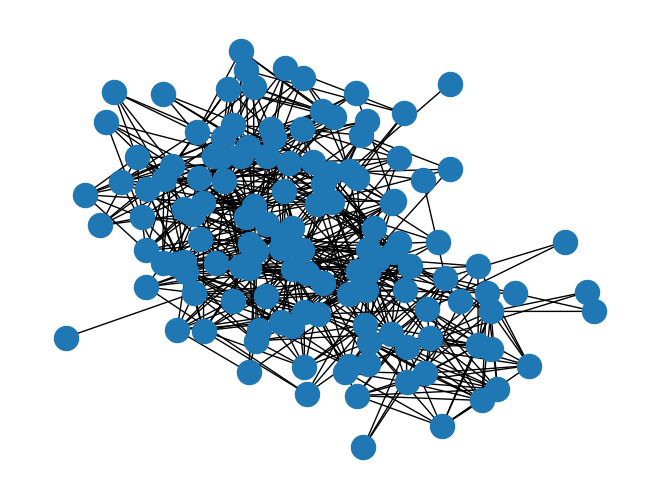

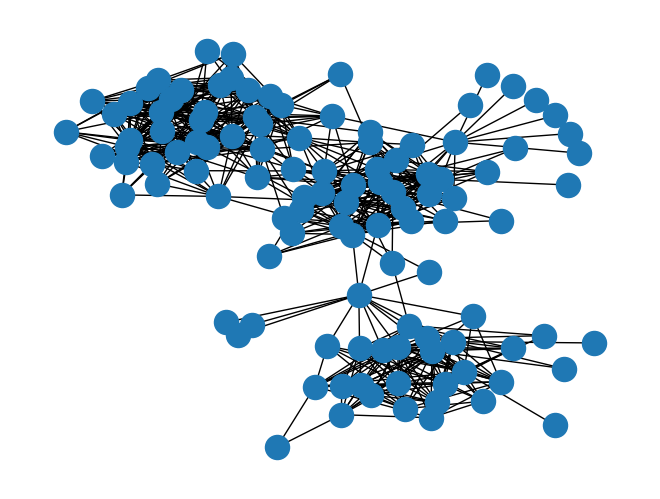

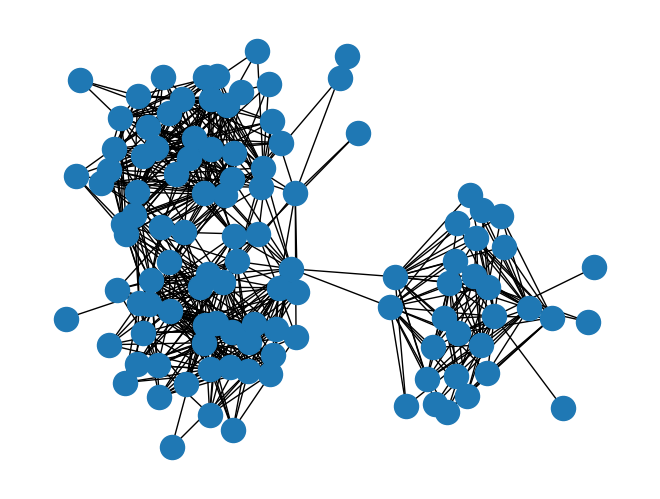

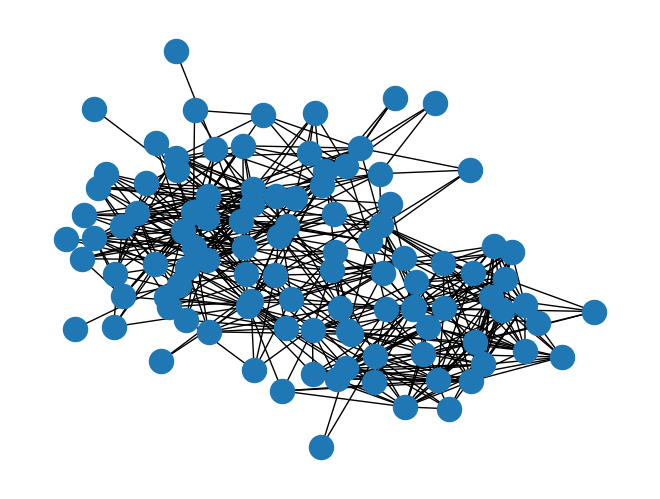

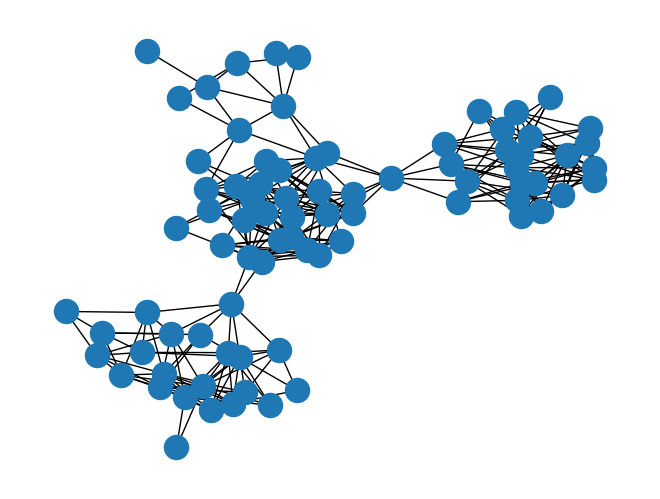

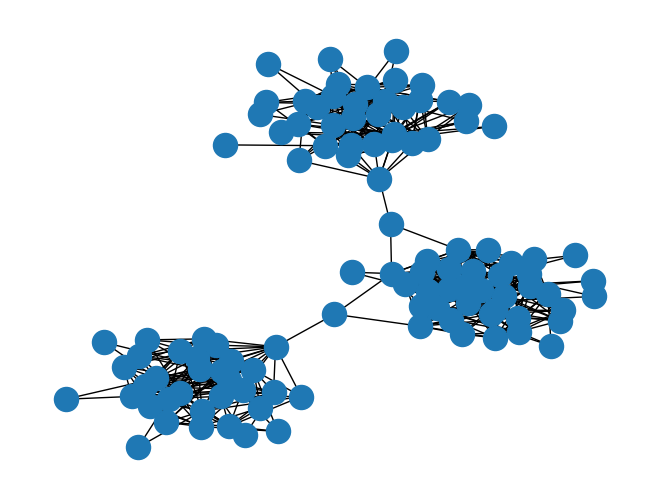

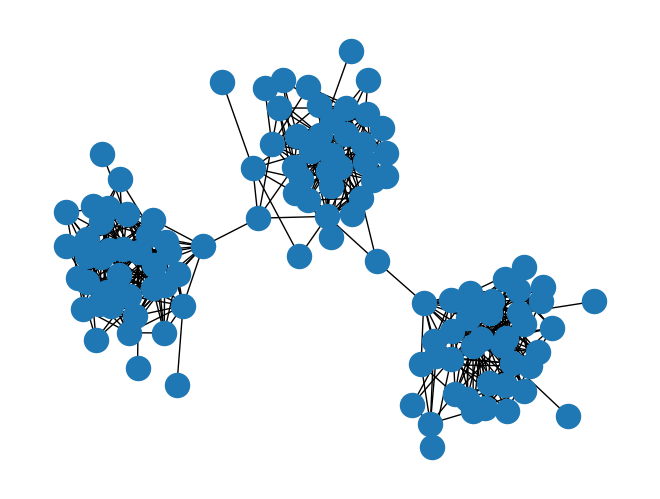

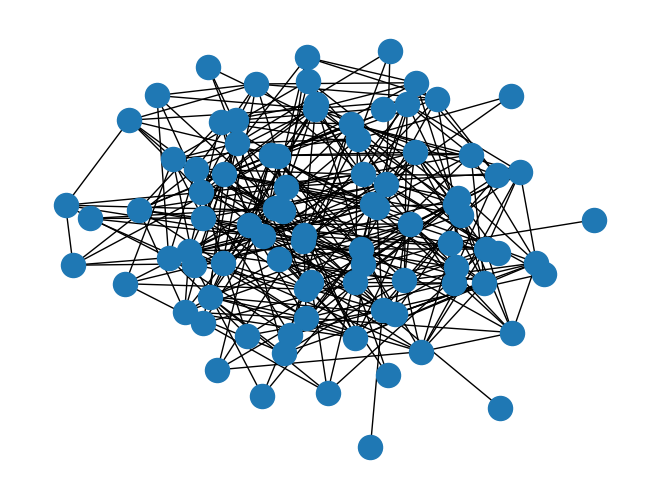

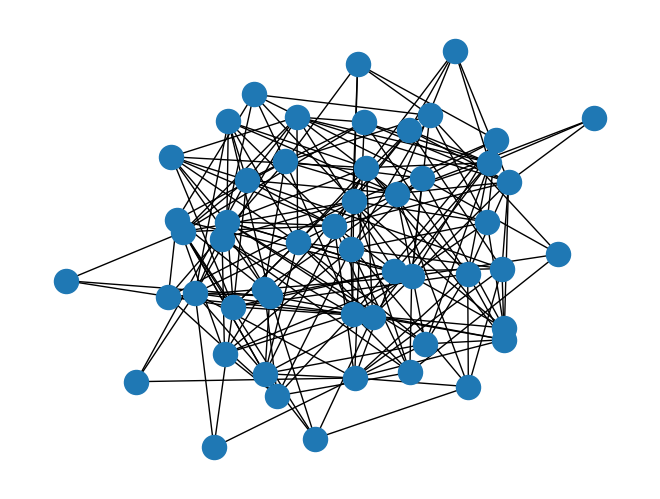

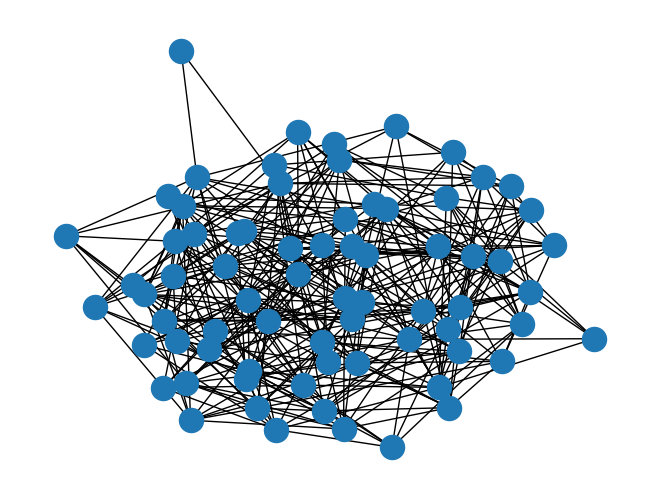

In [23]:
# samples_EIGVEC[:,:-1,:].abs().sum(-1).shape
# samples_EIGVEC[:,:,:] = samples_EIGVEC[:1,:,:]
gen_dev = 'cuda'

# xx = samples_EIGVEC[:,:-1,:].to(gen_dev)
# yy = samples_EIGVEC[:,-1,:].to(gen_dev)
xx = xx_all.to(gen_dev)
yy = yy_all.to(gen_dev)
mask = xx.abs().sum(-1)>1e-6

# xx,yy = train_set.unscale_xy(xx,yy)
xx = xx/xx.norm(dim=1)[:,None,:]


with torch.no_grad():
#     mask = torch.ones(1,xx.shape[1],xx.shape[1]).expand(xx.shape[0],xx.shape[1]).to(gen_dev)
    inno =  torch.randn(list(mask.shape[:2])+[model_denoise.latent_dim], device=gen_dev)*1e-2
    fake_adj,_,_ = model_denoise(inno, yy[:,0], xx, mask)
    
fake_adj=fake_adj.cpu()

import scipy
LLLall_ =[]

di=0
graph_pred_list = []
for i, A in enumerate(fake_adj.cpu()):
    A = (A>0.5).float()
    mask = A.sum(-1)>0
    G = nx.Graph(A[mask,:][:,mask].numpy())
    graph_pred_list.append(G)


#display
for A in graph_pred_list[:10]:
    nx.draw_kamada_kawai(A)
    plt.show()
        

    

In [24]:
test_set.get_extra_data()
train_set.get_extra_data()

#compute metrics
graph_test_list = [] #should be on test set graphs
for jj in range(len(test_set)):
    laplacian_matrix = np.array(test_set[jj][-3].cpu())[:test_set[jj][-2],:test_set[jj][-2]]
    Aori = np.copy(laplacian_matrix)
    np.fill_diagonal(Aori,0)
    Aori= Aori*(-1)
    graph_test_list.append(nx.from_numpy_array(Aori)) 

graph_train_list = []
for jj in range(len(train_set)):
    laplacian_matrix = np.array(train_set[jj][-3].cpu())[:train_set[jj][-2],:train_set[jj][-2]]
    Aori = np.copy(laplacian_matrix)
    np.fill_diagonal(Aori,0)
    Aori= Aori*(-1)
    graph_train_list.append(nx.from_numpy_array(Aori)) 

graph_pred_list_remove_empty = [G for G in graph_pred_list if not G.number_of_nodes() == 0][:len(test_set)]




degree, cluster, orbit, unique, novel, spectral = 0,0,0,0,0,0
if len(graph_pred_list_remove_empty)>0:
    degree = degree_stats( graph_test_list,graph_pred_list_remove_empty, compute_emd=False)
    cluster = clustering_stats( graph_test_list,graph_pred_list_remove_empty, compute_emd=False)
    orbit = orbit_stats_all(graph_test_list, graph_pred_list_remove_empty, compute_emd=False)
    unique,novel,_ = eval_fraction_unique_non_isomorphic_valid(graph_pred_list_remove_empty,graph_train_list)
    spectral = spectral_stats(graph_test_list, graph_pred_list_remove_empty)

for m in degree, cluster, orbit, unique, novel, spectral:
    print(m)
    
for m_t,m in zip( [train_set.degree, train_set.cluster,  train_set.spectral],[degree, cluster,  spectral]):
    print(m_t, '\t', m/m_t)

0.026837288364063294
0.0568123737488196
0.0
1.0
1.0
0.026655655647712884
tensor(0.0008) 	 tensor(33.9918)
tensor(0.0315) 	 tensor(1.8020)
tensor(0.0026) 	 tensor(10.2378)


In [25]:
graph_pred_list_remove_empty = np.asarray(graph_pred_list,dtype='object')

graph_pred_list_remove_empty[0]
np.asarray([g for g in graph_pred_list if not g.number_of_nodes() == 0],dtype=object)

array([<networkx.classes.graph.Graph object at 0x7fa27022e760>,
      dtype=object)

In [26]:
from sklearn.model_selection import KFold
import random
kf = KFold(n_folds)

random.shuffle(graph_pred_list)
folds = list(kf.split(range(len(graph_pred_list))))

# graph_pred_list_remove_empty = np.asarray(graph_pred_list,dtype='object')

degree = [degree_stats( graph_test_list,[graph_pred_list[i] for i in idx[-1]], compute_emd=False) for idx in folds]
cluster = [clustering_stats( graph_test_list,[graph_pred_list[i] for i in idx[-1]], compute_emd=False) for idx in folds]
spectral = [spectral_stats(graph_test_list, [graph_pred_list[i] for i in idx[-1]]) for idx in folds]

print(f"deg {np.mean(degree)} +- {np.std(degree)}")
print(f"clu {np.mean(cluster)} +- {np.std(cluster)}")
print(f"spe {np.mean(spectral)} +- {np.std(spectral)}")


ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.

In [ ]:
for m_t,m in zip( [train_set.degree, train_set.cluster,  train_set.spectral],[degree, cluster,  spectral]):
    print( f"{np.mean(m)/m_t} +- {np.std(m)/m_t}" )

In [ ]:
7.2335004806518555 +- 1.3455753326416016
5.807243347167969 +- 0.3624463379383087
5.131012439727783 +- 0.7123957872390747